In [1]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Instalacion librerias
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt
import imageio
from skimage.util import random_noise
from PIL import Image, ImageTk
from sklearn.cluster import MeanShift, estimate_bandwidth

In [3]:
# Mis funciones
import funciones_pdi as nf

In [4]:
def calculate_histogram(values, ax):
#     fig, ax = plt.subplots(figsize=(4, 3))
    ax.set(title='Histograma')
    n, bins, patches = ax.hist(values, bins=20, range=(0,1), density=True)    
    altura_total = np.sum(n)
    factor_de_escala = 100 / altura_total
    n *= factor_de_escala
    # Graficar el histograma escalado
    ax.bar(bins[:-1], n, width=np.diff(bins), align="edge", edgecolor='black')
    # Establecer límite en el eje y hasta 100%
    ax.set_ylim(0, 100)
    
def show_images(values, title):
    fig, ax = plt.subplots()
    ax.imshow(values, 'gray')
    ax.set_title(title)
    fig.set_size_inches(18, 10, forward=True)

    fig, ax2 = plt.subplots()
    calculate_histogram(values.flatten(), ax2)

C:\Users\Fabian\AppData\Local\Temp\ipykernel_9616\2655786760.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread('imagenes/ponds.bmp')


0.0 0.9299999999999999


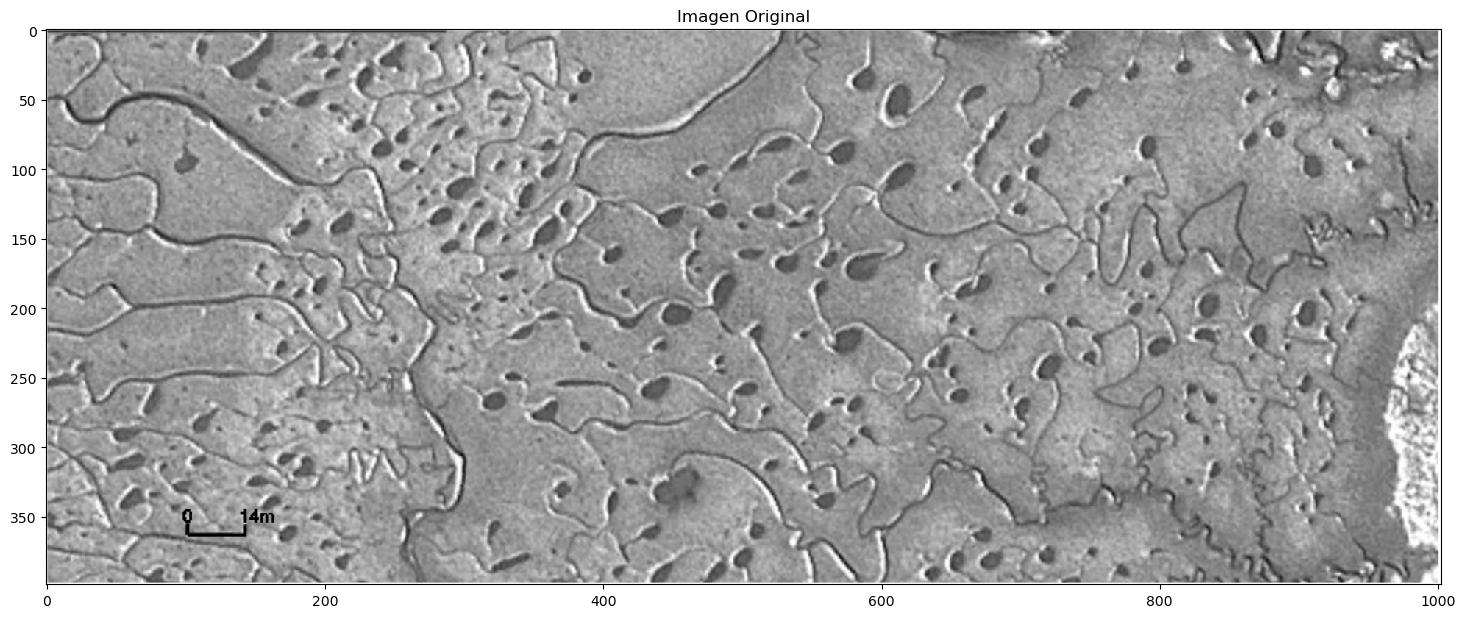

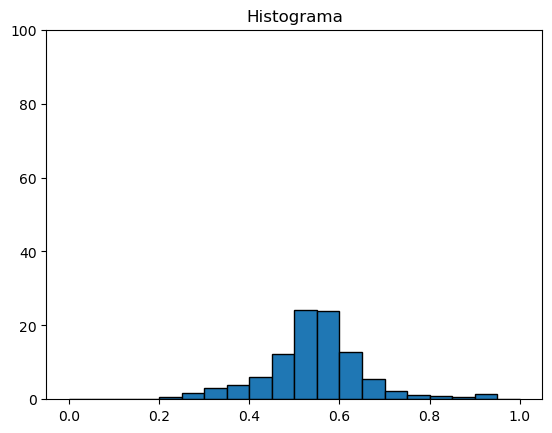

In [5]:
im = imageio.imread('imagenes/ponds.bmp')

im = np.clip(im/255.,0.,1.) #normalizando [0,1]

yiq = np.clip(nf.RGB_to_YIQ(im),0.,1.)
print(yiq.min(), yiq.max())
luminancia = yiq[:,:,0]
show_images(luminancia,'Imagen Original')

0.0 1.0


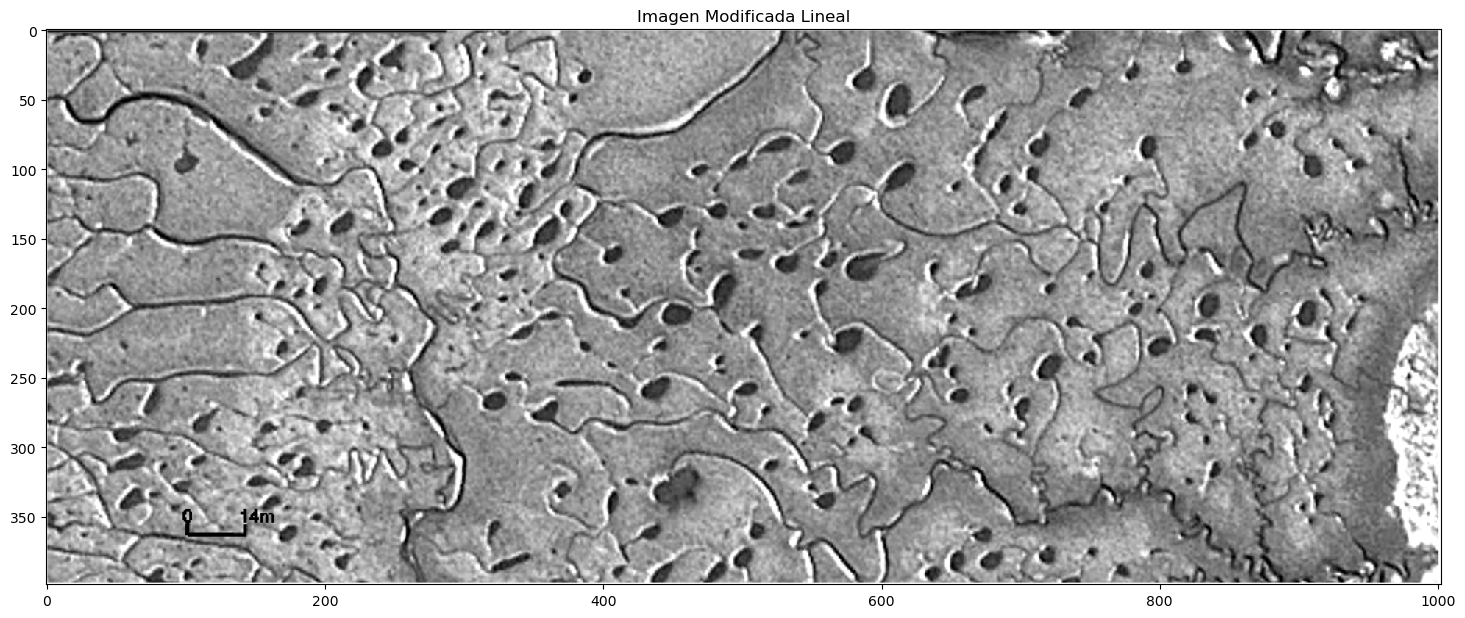

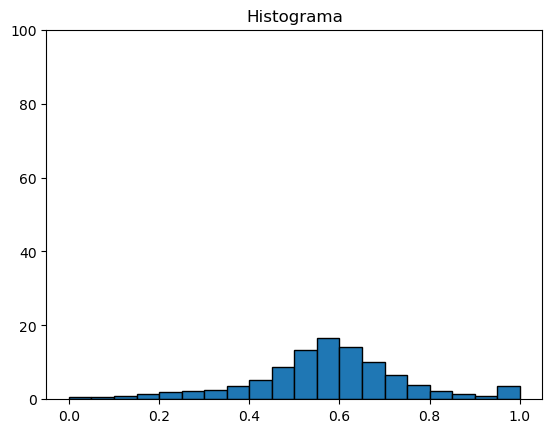

In [6]:
yiq_lineal = nf.histogram_lineal(yiq, 0.2, 0.8)
print(yiq_lineal.min(), yiq_lineal.max())
luminancia_lineal = yiq_lineal[:,:,0]
show_images(luminancia_lineal,'Imagen Modificada Lineal')

In [7]:
img_rgb = nf.YIQ_to_RGB(yiq_lineal)
img_rgb = np.clip((img_rgb*255),0,255).astype(np.uint8)

In [8]:
def MeanShiftFunc(img, quantile):
    # filter to reduce noise
    img = cv.medianBlur(img, 3)

    # flatten the image
    flat_image = img.reshape((-1,3))
    flat_image = np.float32(flat_image)

    bandwidth = estimate_bandwidth(flat_image, quantile=quantile, n_samples=3000)
    ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
    ms.fit(flat_image)
    labeled=ms.labels_


    # get number of segments
    segments = np.unique(labeled)
    #print('Number of segments: ', segments.shape[0])

    # get the average color of each segment
    total = np.zeros((segments.shape[0], 3), dtype=float)
    count = np.zeros(total.shape, dtype=float)
    for i, label in enumerate(labeled):
        total[label] = total[label] + flat_image[i]
        count[label] += 1
    avg = total/count
    avg = np.uint8(avg)

    # cast the labeled image into the corresponding average color
    res = avg[labeled]
    result = res.reshape((img.shape))

    #show the result

    return (result, segments.shape[0])

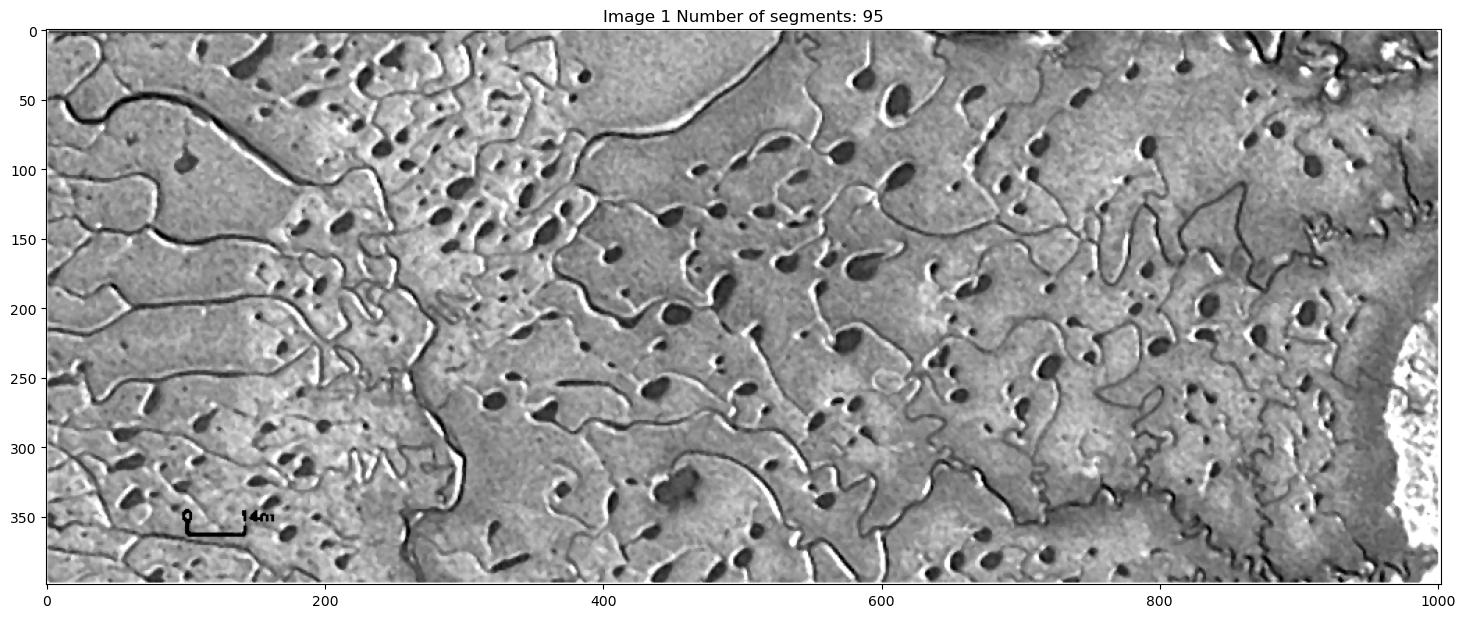

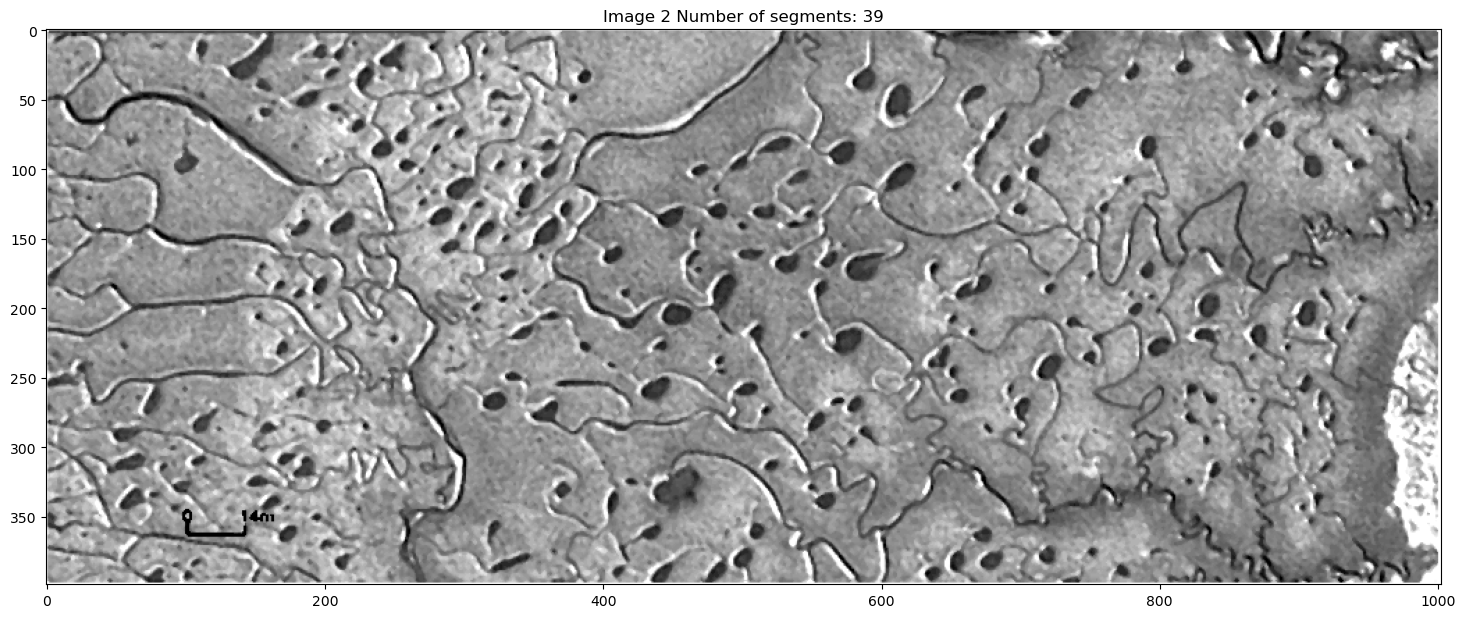

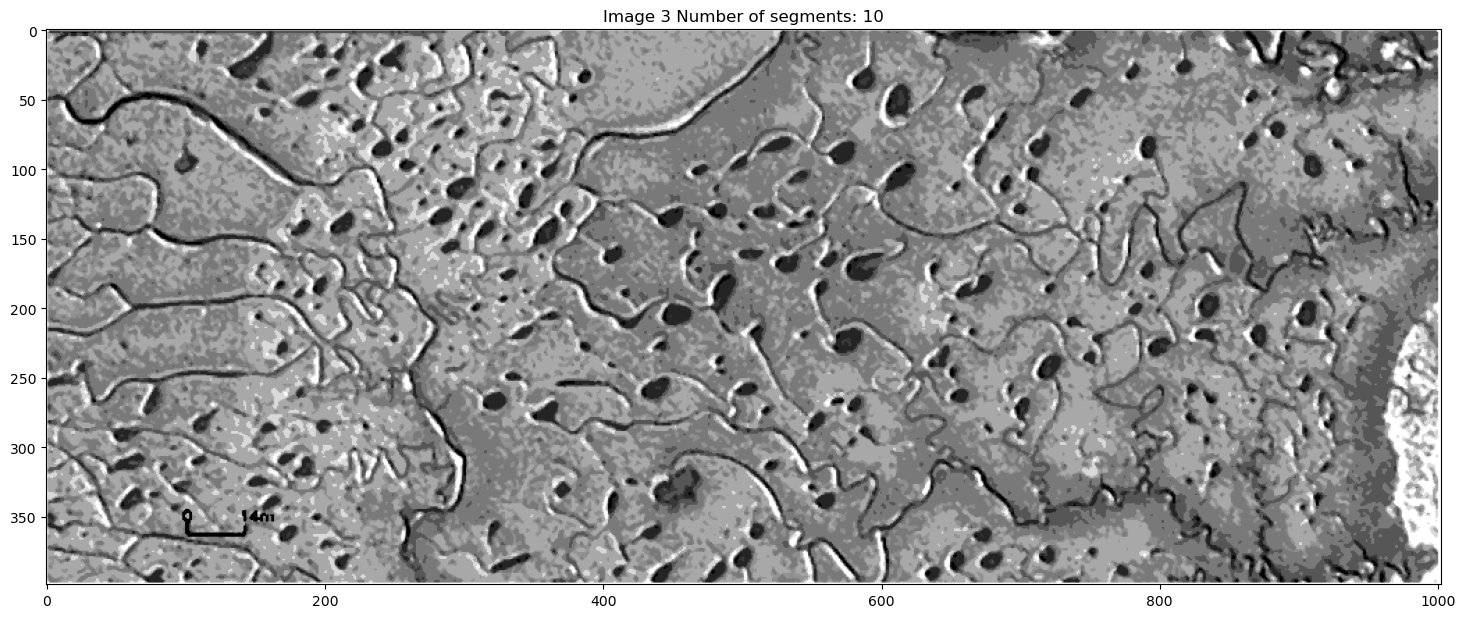

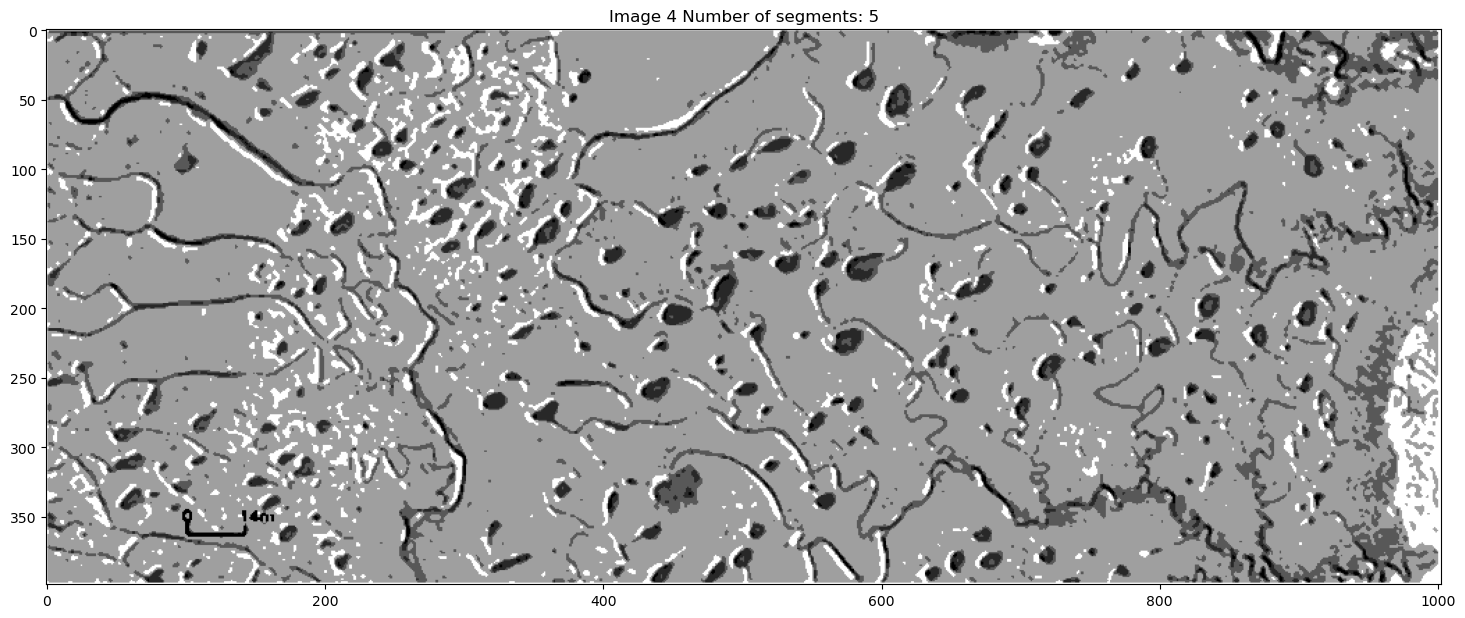

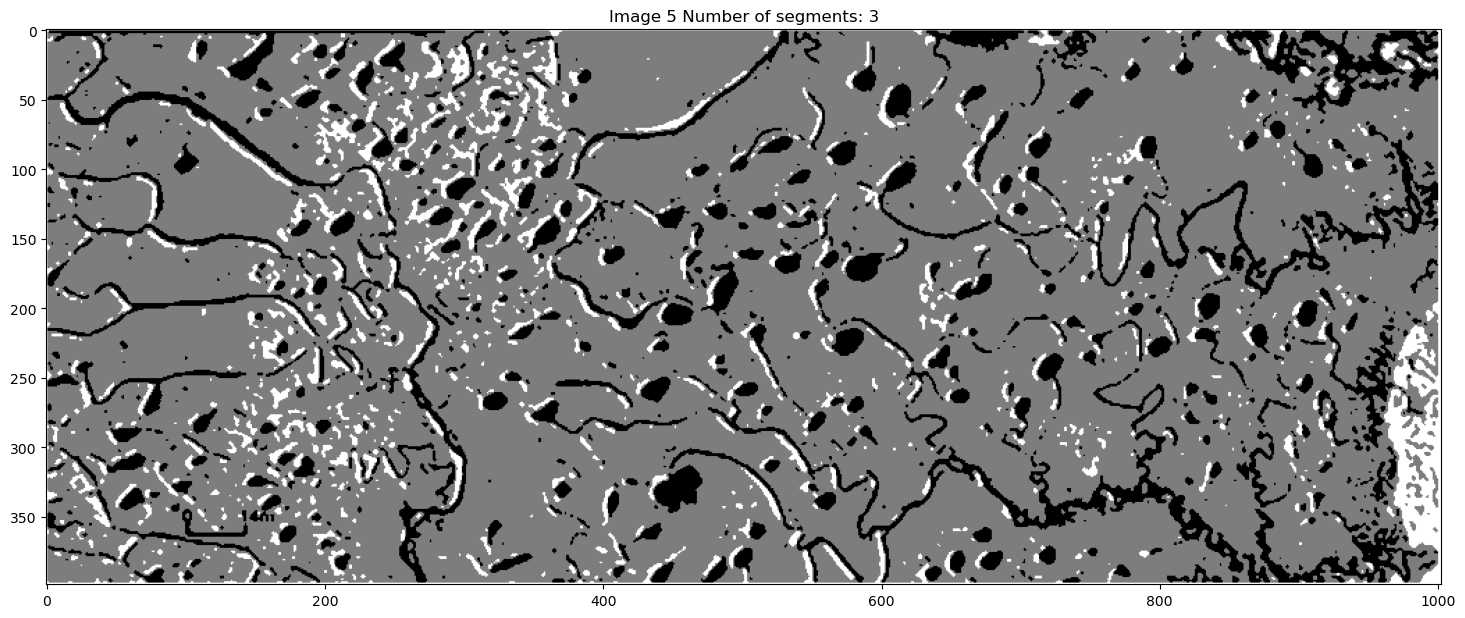

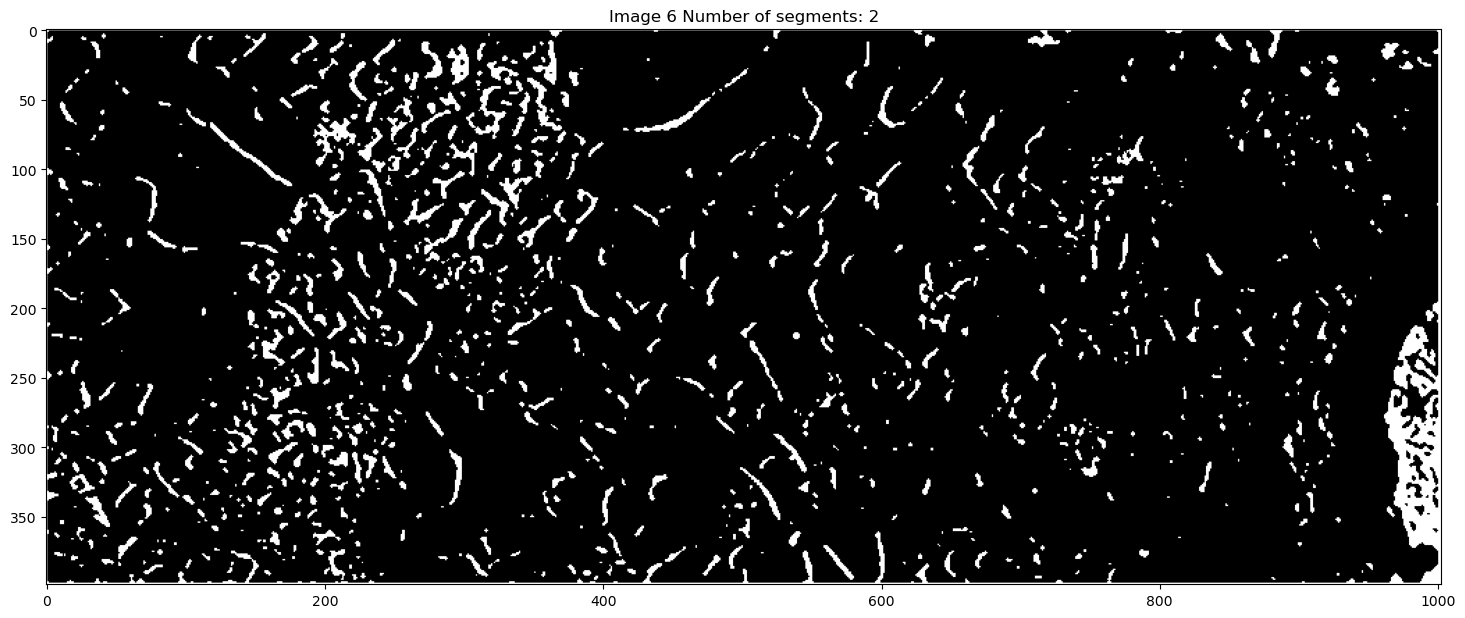

In [9]:
quantile_size = [0.0125, 0.0256 , 0.04, 0.06, 0.12, 0.2]
ms_results = {}
x = 1
for qua_value in quantile_size:
    mean_image, segment = MeanShiftFunc(img_rgb, qua_value)
    img_ms = np.clip(mean_image/255.,0.,1.) #normalizando [0,1]
    yiq_ms = np.clip(nf.RGB_to_YIQ(img_ms),0.,1.)
    luminancia_ms = yiq_ms[:,:,0]
    ms_results[x] = (luminancia_ms, segment)
    fig, ax = plt.subplots()
    ax.imshow(luminancia_ms, 'gray')
    ax.set_title("Image {} Number of segments: {}".format(x,segment))
    fig.set_size_inches(18, 10, forward=True)
    x = x + 1

In [33]:
def binarizacion(bandaY, umbral):
    result = np.zeros(bandaY.shape)
    for x in range(bandaY.shape[0]):
        for y in range(bandaY.shape[1]):
            result[x,y] = 0 if bandaY[x,y] > umbral else 1
    return result

In [34]:
segments = np.unique(ms_results[3][0])
print(segments)

[0.06553333 0.18633725 0.26062353 0.355      0.47625098 0.53735686
 0.55923922 0.62987843 0.7954     0.92315686]


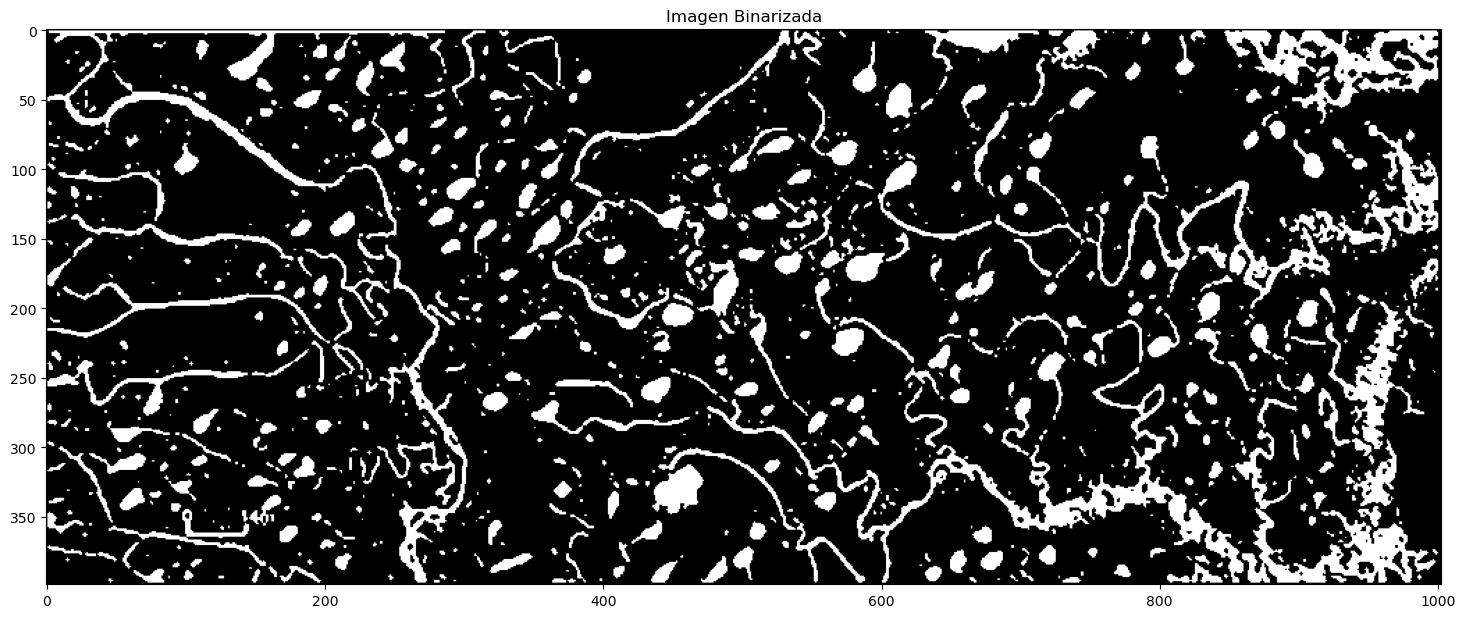

In [35]:
bin = binarizacion(ms_results[3][0], 0.4)
fig, ax = plt.subplots()
ax.imshow(bin, 'gray')
ax.set_title("Imagen Binarizada")
fig.set_size_inches(18, 10, forward=True)

In [55]:
img2 = ms_results[4][0]
img2 = np.clip((bin*255),0,255).astype(np.uint8)

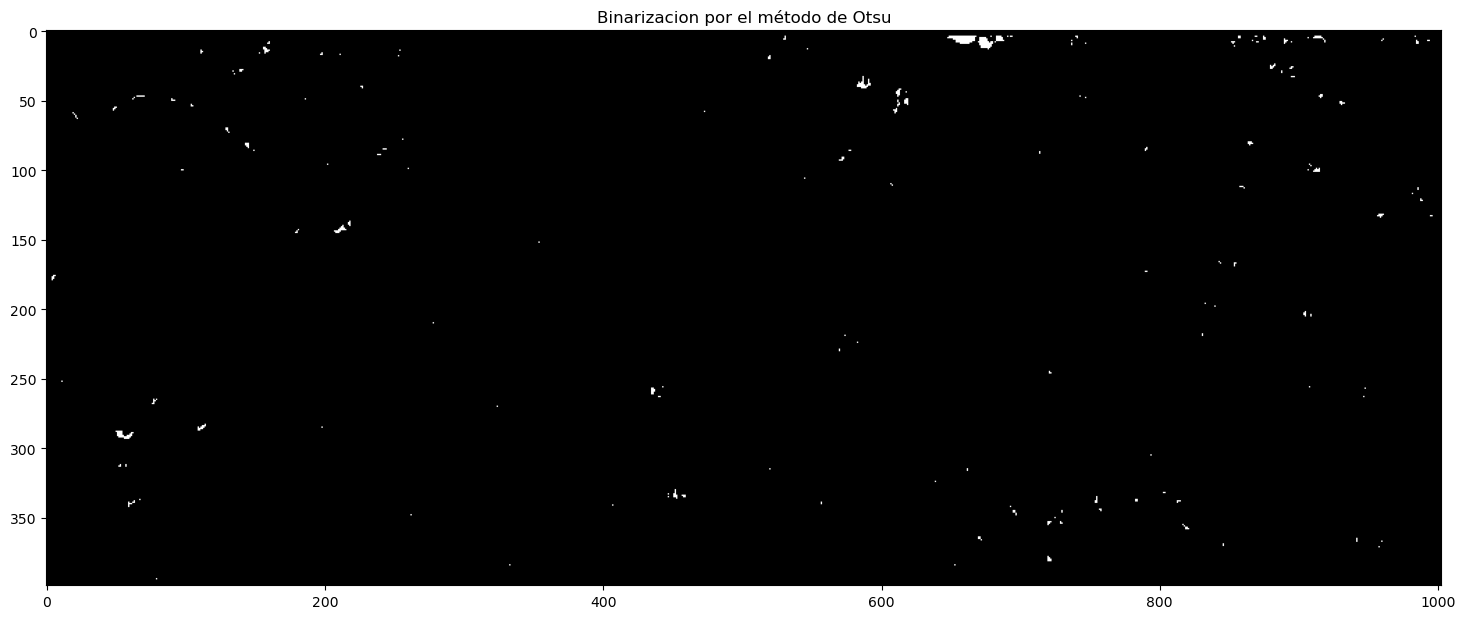

In [74]:
# Umbralización por Otsu
# ret,thresh  = cv.threshold(img2,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
ret, thresh = cv.threshold(img2, 127, 255, 0)
fig, ax = plt.subplots()
ax.imshow(thresh, 'gray')
ax.set_title("Binarizacion por el método de Otsu")
fig.set_size_inches(18, 10, forward=True)

In [36]:
a = ms_results[3][0].shape
a = list(a)
a.append(3)
a = tuple(a)
img_bin = np.zeros(a)
img_bin[:,:,0] = ms_results[3][0]
img_bin[:,:,1] = ms_results[3][0]
img_bin[:,:,2] = ms_results[3][0]

# img_bin = nf.YIQ_to_RGB(img_bin)
img_bin = np.clip((img_bin*255),0,255).astype(np.uint8)

In [67]:
contours, hierarchy = cv.findContours(th2,cv.RETR_TREE ,cv.CHAIN_APPROX_TC89_L1) # cv.CHAIN_APPROX_TC89_L1
print("Nºs de contornos:",len(contours))

Nºs de contornos: 1122


Area of contour 1: 0.0
Perimeter of contour 1: 0.0
Area of contour 2: 0.0
Perimeter of contour 2: 6.3246
Area of contour 3: 0.0
Perimeter of contour 3: 0.0
Area of contour 4: 0.0
Perimeter of contour 4: 0.0
Area of contour 5: 2.5
Perimeter of contour 5: 10.3983
Area of contour 6: 5.5
Perimeter of contour 6: 18.5716
Area of contour 7: 0.0
Perimeter of contour 7: 4.4721
Area of contour 8: 22.5
Perimeter of contour 8: 25.8607
Area of contour 9: 5.5
Perimeter of contour 9: 11.0039
Area of contour 10: 17.0
Perimeter of contour 10: 23.0618
Area of contour 11: 0.0
Perimeter of contour 11: 0.0
Area of contour 12: 0.0
Perimeter of contour 12: 6.3246
Area of contour 13: 0.0
Perimeter of contour 13: 0.0
Area of contour 14: 0.0
Perimeter of contour 14: 6.0
Area of contour 15: 0.0
Perimeter of contour 15: 4.4721
Area of contour 16: 1.5
Perimeter of contour 16: 11.8323
Area of contour 17: 5.0
Perimeter of contour 17: 10.0645
Area of contour 18: 2.5
Perimeter of contour 18: 7.6344
Area of contour 19:

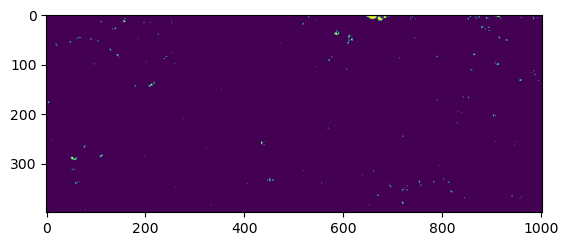

In [69]:
# drawing contours
img2 = th2.copy()
cnt=contours[0]

for i, cnt in enumerate(contours):
   M = cv.moments(cnt) #centroide
   if M['m00'] != 0.0:
      x1 = int(M['m10']/M['m00'])
      y1 = int(M['m01']/M['m00'])

   area = cv.contourArea(cnt)
   perimeter = cv.arcLength(cnt, True)
   perimeter = round(perimeter, 4)
   print(f'Area of contour {i+1}:', area)
   print(f'Perimeter of contour {i+1}:', perimeter)

   img1 = cv.drawContours(img2, [cnt], -1, (0,255,255), 3)
   cv.putText(img2, f'Area :{area}', (x1, y1), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
   cv.putText(img2, f'Perimeter :{perimeter}', (x1, y1+20), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

plt.imshow(img2)